# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com uma camada escondida de 40 neurônios.


## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [2]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

In [3]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [4]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede, uma camada escondida de 40 neurônios

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 40)
        self.ativ1  = nn.ReLU()
        self.layer2 = nn.Linear(40, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.ativ1(x)
        x = self.layer2(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model (
  (layer1): Linear (13 -> 40)
  (ativ1): ReLU ()
  (layer2): Linear (40 -> 1)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [6]:
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, nesterov=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.7)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest,ptt.PrintCallback()]
        )

## Treinamento

In [7]:
trainer.fit(50, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=1)

Start training for 50 epochs
  1:   0.2s   T: 569.63762   V: 479.74041 best
  2:   0.2s   T: 458.43554   V: 356.06200 best
  3:   0.2s   T: 311.60119   V: 185.36353 best
  4:   0.2s   T: 170.94052   V: 42.97507 best
  5:   0.2s   T: 83.18367   V: 12.12594 best
  6:   0.2s   T: 58.76562   V: 14.20512 
  7:   0.2s   T: 49.76055   V: 14.57125 
  8:   0.2s   T: 43.52647   V: 15.79092 
  9:   0.2s   T: 38.69457   V: 15.81614 
 10:   0.2s   T: 34.64261   V: 14.33031 
 11:   0.2s   T: 32.06265   V: 14.71130 
 12:   0.2s   T: 30.08523   V: 15.05100 
 13:   0.2s   T: 28.25183   V: 16.02793 
 14:   0.2s   T: 26.82583   V: 14.66561 
 15:   0.2s   T: 26.01363   V: 15.17550 
 16:   0.2s   T: 24.97105   V: 15.24326 
 17:   0.2s   T: 24.35156   V: 15.26007 
 18:   0.2s   T: 23.73434   V: 14.77331 
 19:   0.2s   T: 23.20941   V: 14.23071 
 20:   0.2s   T: 22.57195   V: 14.31856 
 21:   0.2s   T: 22.07239   V: 13.95506 
 22:   0.2s   T: 21.47195   V: 13.93632 
 23:   0.2s   T: 20.87767   V: 13.44902 
 

## Avaliação

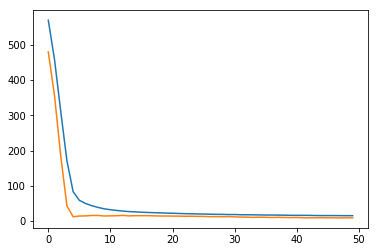

In [8]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [9]:
trainer.load_state('../../models/bostonhousing')

In [10]:
eval = trainer.evaluate(x_train,y_train)
eval

evaluate: 50/50 ok


{'losses': 14.046066488084115}

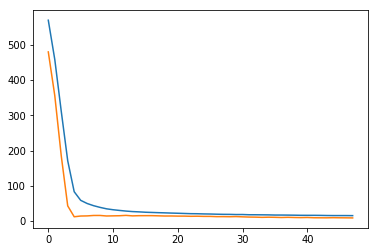

In [11]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [12]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 8.851925293516741
RMSE: 2.9752185287


# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
